# Code

In [1]:
# !apt update
# !apt install ffmpeg libsm6 libxext6 -y
# !pip install opencv-python
# !pip install --upgrade pip

import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

### Utils

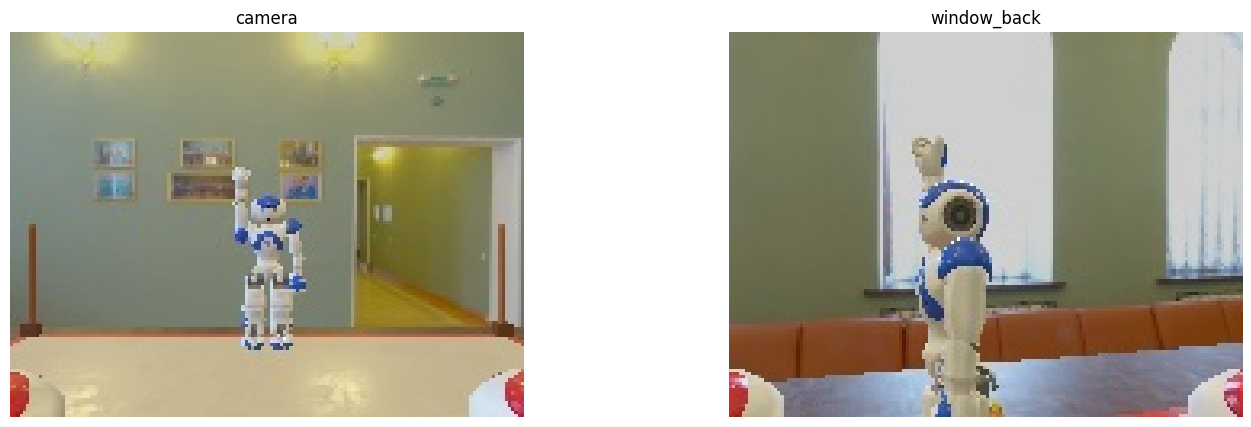

In [2]:
def show(images, scale_percent=100, txt="", size=1, verb=False):
    
    assert type(scale_percent) == int, "The scaling percentage must be an integer"
    assert type(txt) == str or type(txt[0]) == str, "Use strings for txt"
    
    if type(images) == list and len(images) == 1: images = images[0]
    
    if type(images) != list: 
        fig, ax = plt.subplots(1,1,figsize=(17,5))
        
        img = images.copy()

        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)

        dim = (width, height)
        if verb: print(img.min(),img.max())
            
        img = cv2.resize(img,dim)
        img[0,0] = 0
        img[-1,-1] = 255
        
        cmap = 'gray' if len(img.shape) == 2 else None
        ax.imshow(img,cmap=cmap)
        ax.axis('off')
        if txt != "": ax.set_title(txt)
    else:
        l = len(images)
        fig, ax = plt.subplots(1,l,figsize=(17,5))

        for i,img in enumerate(images):
            
            img = img.copy()
            
            width = int(img.shape[1] * scale_percent / 100)
            height = int(img.shape[0] * scale_percent / 100)

            dim = (width, height)
            if verb: print(img.min(),img.max())
            
            img = cv2.resize(img,dim)
            #img[0,0] = 0
            #img[-1,-1] = 255
                
            cmap = 'gray' if len(img.shape) == 2 else None
            ax[i].imshow(img,cmap=cmap)
            ax[i].axis('off')
            if i < len(txt) and txt[i] != "": ax[i].set_title(txt[i])
    plt.show()
    cv2.IMREAD_COLOR

im1 = np.asarray(PIL.Image.open("controllers/camera.jpg"))
im2 = np.asarray(PIL.Image.open("controllers/window_back.jpeg"))
show([im1,im2],txt=["camera","window_back"])

In [3]:
def plot_in_range(image, scale=False):
    if scale:
        minValue = np.amin(image)
        maxValue = np.amax(image)
        plt.imshow((image-minValue)/(maxValue-minValue))
    else:
        plt.imshow(image)
    plt.show()

In [4]:
def plot_histogram(image):
    plt.hist(image.ravel(),256,[0,256])
    plt.show()

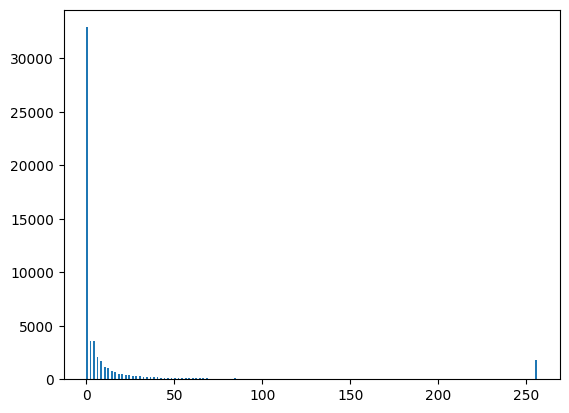

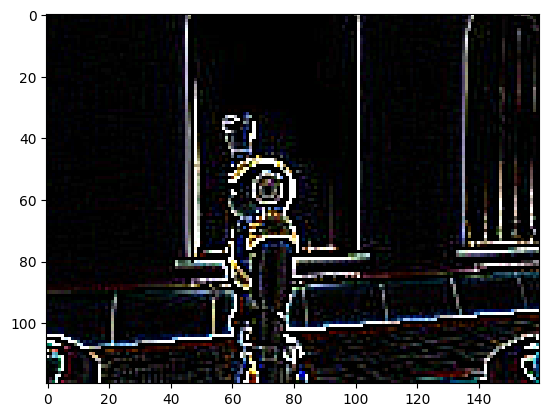

In [5]:
img = im2.copy()
laplacian = cv2.Laplacian(img, cv2.CV_8U, ksize=3)
plot_histogram(laplacian)
plot_in_range(laplacian)

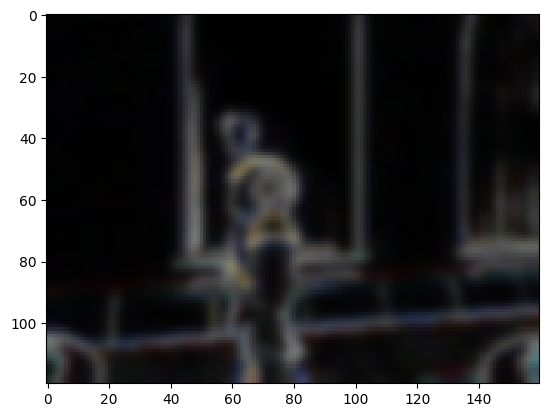

In [6]:
# gaussian blur on image
blur = cv2.GaussianBlur(laplacian, (0,0), 2)
plot_in_range(blur)

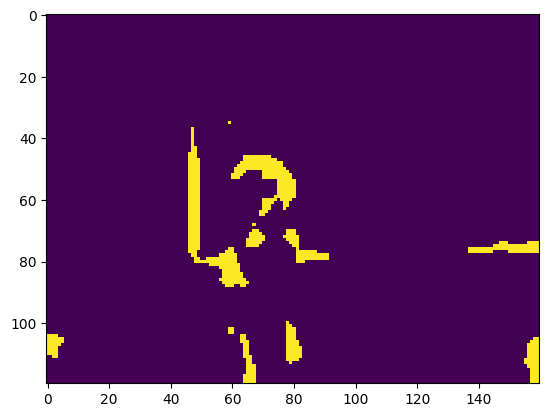

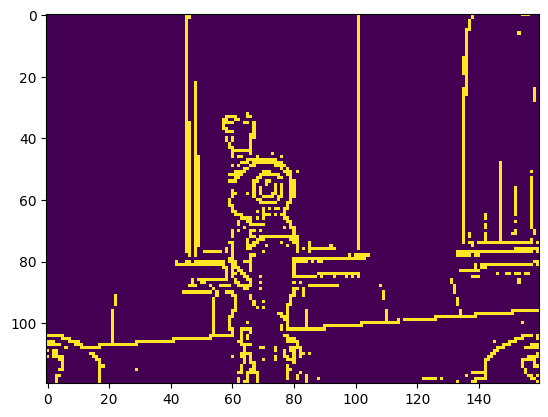

In [7]:
# threshold img to binary at intensity 80
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)
plot_in_range(thresh)

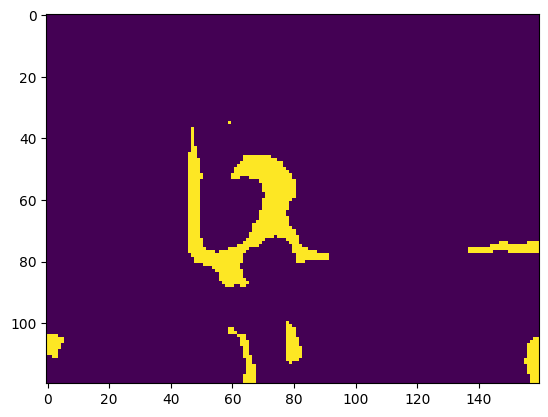

In [72]:
# morphological closing with a circle kernel of size "size"
size = 5
x, y = np.ogrid[-size:size+1, -size:size+1]
circle = x**2 + y**2 <= size**2
circle = circle.astype(np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, circle)
plot_in_range(closing)


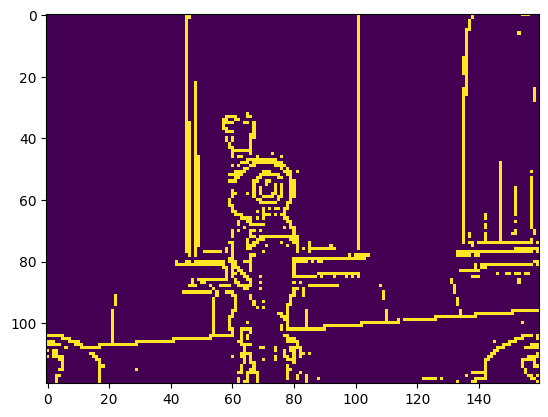

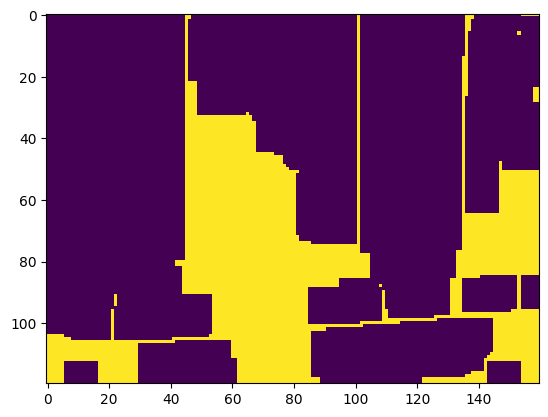

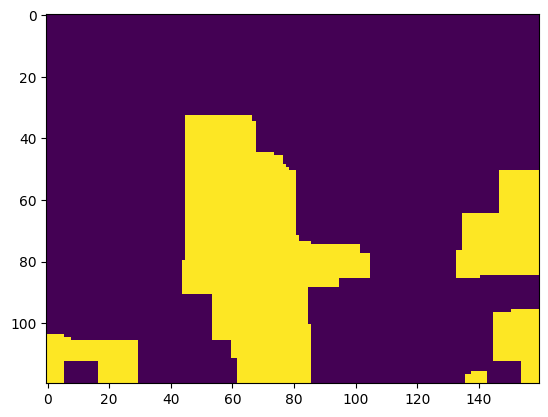

In [16]:
gray = cv2.cvtColor(laplacian, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)
plot_in_range(thresh)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11)))
plot_in_range(closing)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
plot_in_range(opening)


65 65


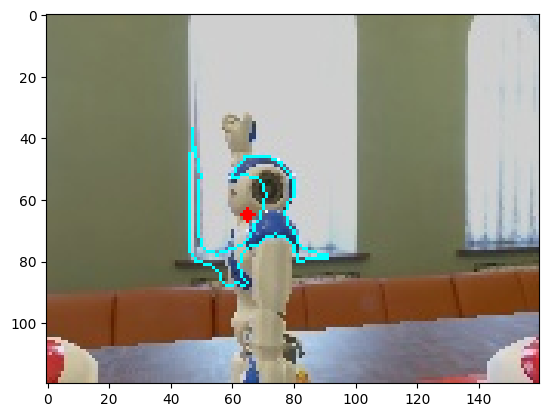

In [74]:
# detect largest contour
contours, hierarchy = cv2.findContours(
    closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
largest_contour = contours[0]
M = cv2.moments(largest_contour)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
print(cx, cy)

# draw largest contour on original image
# mask = np.zeros(img.shape, np.uint8)
mask = img.copy()
cv2.drawContours(mask, [largest_contour], 0, (0, 255, 255), 1)
mask = cv2.circle(mask, (cx, cy), radius=2, color=(255, 0, 0), thickness=-1)
plot_in_range(mask)


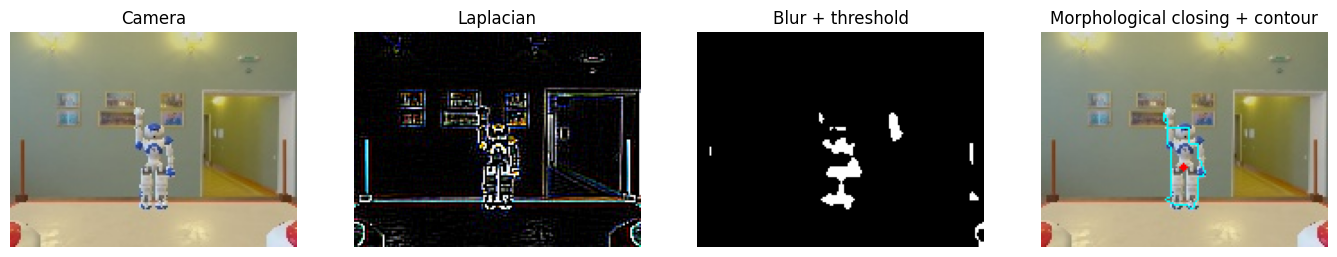

In [13]:
img = im1.copy()
# plot_histogram(laplacian)
# plot_in_range(laplacian)

# The robot is supposed to be located at a concentration of high color changes (big Laplacian values)
laplacian = cv2.Laplacian(img, cv2.CV_8U, ksize=3)
# those spikes are then smoothed out using a Gaussian blur to get blurry blobs
blur = cv2.GaussianBlur(laplacian, (0, 0), 2)
# We apply a threshold to get a binary image of potential robot locations
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)
# the binary image is then dilated to merge small groups of blobs together
closing = cv2.morphologyEx(
    thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15)))
# the largest contour is then picked and its centroid is used as the robot's location
contours, hierarchy = cv2.findContours(
    closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# prepares robot window image
output = img.copy()

# get centroid of the largest contour, default to the image's center
# and draw the contour + centroid on the output image
if len(contours) > 0:
    largest_contour = contours[0]
    M = cv2.moments(largest_contour)
    try:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
    except ZeroDivisionError:
        cx = img.shape[1]//2
        cy = img.shape[0]//2

    cv2.drawContours(
        output, [largest_contour], 0, (0, 255, 255), 1)
else:
    # get center of image
    cx = img.shape[1]//2
    cy = img.shape[0]//2
output = cv2.circle(output, (cx, cy), radius=2,
                    color=(255, 0, 0), thickness=-1)
show([img, laplacian, thresh, output],txt=["Camera","Laplacian","Blur + threshold","Morphological closing + contour"])